In [1]:
!pip install dlt[duckdb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.9/728.9 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.0 MB/s eta 0:00:00


# Assessing your needs
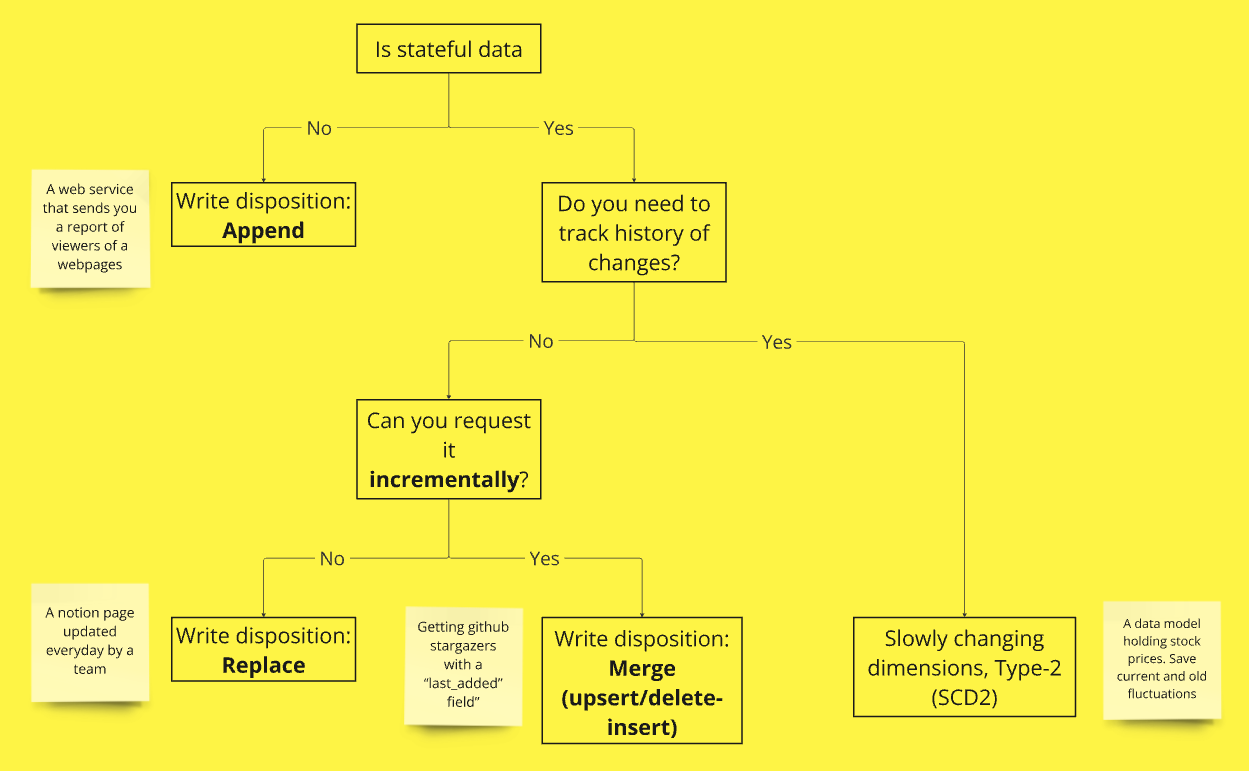

## What is stateful data? 👀

 Refers to data that has a state which can change over time.

 **Examples:**

- Stateful data:
  - A user property on a website -> user can change their profile picture.
- Stateless data:
  - Page views on a website -> can only be recorded once and not changed.

# Recap

We've covered:

- Append with `dlt`
- Replace with `dlt`
- Merge (delete-insert) with `dlt`

## Delete-Insert Strategy Definition

The `delete-insert` strategy loads data to a `staging` dataset, deduplicates the `staging` data if a `primary_key` is provided, **deletes** the data from the destination using `merge_key` and `primary_key`, and then **inserts** the new records.

All of this happens in a single atomic transaction for a parent and all child tables.

# Merging Strategies in this Notebook

- Upsert
- SCD2

# Upsert Strategy

The upsert merge strategy does `primary_key` based upserts:

- update record if key exists in target table
- insert record if key does not exist in target table

You can delete records with the `hard_delete` hint.

```
@dlt.resource(
    write_disposition={"disposition": "merge", "strategy": "upsert"},
    primary_key="my_primary_key"
)
def my_upsert_resource():
    ...
...
```

## Difference between upsert and delete-insert

1. needs a `primary_key`
2. expects this `primary_key` to be unique (`dlt` does not deduplicate)
3. does not support `merge_key`
4. uses MERGE or UPDATE operations to process updates

***Is not supported in duckdb destionation.** List of supported destinations can be found in [docs](https://dlthub.com/docs/general-usage/incremental-loading#upsert-strategy).

# SCD2 - Definition & Demo

## Definition

dlt can create Slowly Changing Dimension Type 2 (SCD2) destination tables for dimension tables that change in the source.

The resource is expected to provide a full extract of the source table each run.

A row hash is stored in `_dlt_id` and used as surrogate key to identify source records that have been inserted, updated, or deleted.

## Demo

In [2]:
import dlt
import pandas as pd
import duckdb

In [3]:
# changing old Harry Potter example

@dlt.resource(write_disposition={"disposition": "merge",
                                 "strategy": "scd2"}
              )
def students(entries):
    for entry in entries:
        yield {
            "name": [entry[0]],
            "designation": ["student"],
            "date_started": [entry[1]]
        }

In [4]:
# the rest of the code is the same:

# declare the pipeline
pipeline = dlt.pipeline(pipeline_name='hogwarts_pipeline',
                        destination='duckdb',
                        dataset_name='hogwarts')

# first Harry joins:
pipeline.run(students([("Harry Potter", "1991-09-01T09:00:00Z")]), table_name="creatures")

LoadInfo(pipeline=<dlt.pipeline.pipeline.Pipeline object at 0x7e9af0f25870>, metrics={'1725323711.9809723': [{'started_at': DateTime(2024, 9, 3, 0, 35, 12, 451226, tzinfo=Timezone('UTC')), 'finished_at': DateTime(2024, 9, 3, 0, 35, 14, 772904, tzinfo=Timezone('UTC')), 'job_metrics': {'_dlt_pipeline_state.5786b37133.insert_values': LoadJobMetrics(job_id='_dlt_pipeline_state.5786b37133.insert_values', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725323711.9809723/started_jobs/_dlt_pipeline_state.5786b37133.0.insert_values', table_name='_dlt_pipeline_state', started_at=DateTime(2024, 9, 3, 0, 35, 12, 697245, tzinfo=Timezone('UTC')), finished_at=DateTime(2024, 9, 3, 0, 35, 12, 712502, tzinfo=Timezone('UTC')), state='completed', remote_url=None), 'creatures__designation.deac4fff55.insert_values': LoadJobMetrics(job_id='creatures__designation.deac4fff55.insert_values', file_path='/var/dlt/pipelines/hogwarts_pipeline/load/normalized/1725323711.9809723/started_jobs/creature

### Observing the data

In [5]:
conn = duckdb.connect(f'{pipeline.pipeline_name}.duckdb')

# helper function
def show_tables(tables, CONN=conn):
  for table in tables:
    print(CONN.sql(f'select * from {table}'))

In [6]:
conn.sql('SHOW ALL TABLES')

┌───────────────────┬──────────────────┬──────────────────────┬───┬──────────────────────┬───────────┐
│     database      │      schema      │         name         │ … │     column_types     │ temporary │
│      varchar      │     varchar      │       varchar        │   │      varchar[]       │  boolean  │
├───────────────────┼──────────────────┼──────────────────────┼───┼──────────────────────┼───────────┤
│ hogwarts_pipeline │ hogwarts         │ _dlt_loads           │ … │ [VARCHAR, VARCHAR,…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ _dlt_pipeline_state  │ … │ [BIGINT, BIGINT, V…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ _dlt_version         │ … │ [BIGINT, BIGINT, T…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ creatures            │ … │ [TIMESTAMP WITH TI…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ creatures__date_st…  │ … │ [TIMESTAMP WITH TI…  │ false     │
│ hogwarts_pipeline │ hogwarts         │ creatures__designa…  │ … │ [VARC

It is normalized for every column and each generated table has a `staging` table. Let's see what the difference is so far.

In [7]:
# look at tables
show_tables(['hogwarts.creatures',
             'hogwarts.creatures__name'])

┌───────────────────────────────┬──────────────────────────┬────────────────────┬────────────────┐
│        _dlt_valid_from        │      _dlt_valid_to       │    _dlt_load_id    │    _dlt_id     │
│   timestamp with time zone    │ timestamp with time zone │      varchar       │    varchar     │
├───────────────────────────────┼──────────────────────────┼────────────────────┼────────────────┤
│ 2024-09-03 00:35:11.980972+00 │ NULL                     │ 1725323711.9809723 │ WIBEbK9iXxP0Qg │
└───────────────────────────────┴──────────────────────────┴────────────────────┴────────────────┘

┌──────────────┬────────────────┬────────────────┬───────────────┬────────────────┐
│    value     │    _dlt_id     │ _dlt_parent_id │ _dlt_list_idx │  _dlt_root_id  │
│   varchar    │    varchar     │    varchar     │     int64     │    varchar     │
├──────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│ Harry Potter │ F5hpFJoP/kpITQ │ WIBEbK9iXxP0Qg │             0 │ WI

In [8]:
# look at staging tables
show_tables(['hogwarts_staging.creatures',
             'hogwarts_staging.creatures__name'])

┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────┐
│     _dlt_valid_from      │      _dlt_valid_to       │    _dlt_load_id    │    _dlt_id     │
│ timestamp with time zone │ timestamp with time zone │      varchar       │    varchar     │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────┤
│ NULL                     │ NULL                     │ 1725323711.9809723 │ WIBEbK9iXxP0Qg │
└──────────────────────────┴──────────────────────────┴────────────────────┴────────────────┘

┌──────────────┬────────────────┬────────────────┬───────────────┬────────────────┐
│    value     │    _dlt_id     │ _dlt_parent_id │ _dlt_list_idx │  _dlt_root_id  │
│   varchar    │    varchar     │    varchar     │     int64     │    varchar     │
├──────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│ Harry Potter │ F5hpFJoP/kpITQ │ WIBEbK9iXxP0Qg │             0 │ WIBEbK9iXxP0Qg │
└──────────────

### Adding the rest of the students

In [9]:
# then, we append Ron and Hermione:
pipeline.run(students([("Ronald Weasley", "1991-09-01T09:00:00Z"),
                         ("Hermione Granger", "1991-09-01T09:00:00Z")]), table_name="creatures")

# then perhaps Ginny:
info = pipeline.run(students([("Ginny Weasley", "1991-09-01T09:00:00Z")]), table_name="creatures")

Look at data again

In [10]:
# look at tables
show_tables(['hogwarts.creatures',
             'hogwarts.creatures__name'])

┌───────────────────────────────┬───────────────────────────────┬────────────────────┬────────────────┐
│        _dlt_valid_from        │         _dlt_valid_to         │    _dlt_load_id    │    _dlt_id     │
│   timestamp with time zone    │   timestamp with time zone    │      varchar       │    varchar     │
├───────────────────────────────┼───────────────────────────────┼────────────────────┼────────────────┤
│ 2024-09-03 00:35:11.980972+00 │ 2024-09-03 00:41:55.578054+00 │ 1725323711.9809723 │ WIBEbK9iXxP0Qg │
│ 2024-09-03 00:41:55.578054+00 │ 2024-09-03 00:41:58.155724+00 │ 1725324115.5780544 │ 5zXTVl1jHoej1g │
│ 2024-09-03 00:41:55.578054+00 │ 2024-09-03 00:41:58.155724+00 │ 1725324115.5780544 │ AroiUDKM+62DXA │
│ 2024-09-03 00:41:58.155724+00 │ NULL                          │ 1725324118.155724  │ UZ4kcLhVEsckpQ │
└───────────────────────────────┴───────────────────────────────┴────────────────────┴────────────────┘

┌──────────────────┬────────────────┬────────────────┬─────────

In [11]:
# look at staging tables
show_tables(['hogwarts_staging.creatures',
             'hogwarts_staging.creatures__name'])

┌──────────────────────────┬──────────────────────────┬───────────────────┬────────────────┐
│     _dlt_valid_from      │      _dlt_valid_to       │   _dlt_load_id    │    _dlt_id     │
│ timestamp with time zone │ timestamp with time zone │      varchar      │    varchar     │
├──────────────────────────┼──────────────────────────┼───────────────────┼────────────────┤
│ NULL                     │ NULL                     │ 1725324118.155724 │ UZ4kcLhVEsckpQ │
└──────────────────────────┴──────────────────────────┴───────────────────┴────────────────┘

┌───────────────┬────────────────┬────────────────┬───────────────┬────────────────┐
│     value     │    _dlt_id     │ _dlt_parent_id │ _dlt_list_idx │  _dlt_root_id  │
│    varchar    │    varchar     │    varchar     │     int64     │    varchar     │
├───────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│ Ginny Weasley │ p/9HP7QI25RLmw │ UZ4kcLhVEsckpQ │             0 │ UZ4kcLhVEsckpQ │
└───────────────

### Making the change

In [12]:
# add the change to Ginny's joining year:

info = pipeline.run(students([("Ginny Weasley", "1992-09-01T09:00:00Z")]), table_name="creatures")

The impact on the data:

In [13]:
# look at tables
show_tables(['hogwarts.creatures',
             'hogwarts.creatures__name'])

┌───────────────────────────────┬───────────────────────────────┬────────────────────┬────────────────┐
│        _dlt_valid_from        │         _dlt_valid_to         │    _dlt_load_id    │    _dlt_id     │
│   timestamp with time zone    │   timestamp with time zone    │      varchar       │    varchar     │
├───────────────────────────────┼───────────────────────────────┼────────────────────┼────────────────┤
│ 2024-09-03 00:35:11.980972+00 │ 2024-09-03 00:41:55.578054+00 │ 1725323711.9809723 │ WIBEbK9iXxP0Qg │
│ 2024-09-03 00:41:55.578054+00 │ 2024-09-03 00:41:58.155724+00 │ 1725324115.5780544 │ 5zXTVl1jHoej1g │
│ 2024-09-03 00:41:55.578054+00 │ 2024-09-03 00:41:58.155724+00 │ 1725324115.5780544 │ AroiUDKM+62DXA │
│ 2024-09-03 00:41:58.155724+00 │ 2024-09-03 00:44:51.903556+00 │ 1725324118.155724  │ UZ4kcLhVEsckpQ │
│ 2024-09-03 00:44:51.903556+00 │ NULL                          │ 1725324291.9035556 │ l5TTk1vJLo8qEg │
└───────────────────────────────┴───────────────────────────────

In [14]:
# look at staging tables
show_tables(['hogwarts_staging.creatures',
             'hogwarts_staging.creatures__name'])

┌──────────────────────────┬──────────────────────────┬────────────────────┬────────────────┐
│     _dlt_valid_from      │      _dlt_valid_to       │    _dlt_load_id    │    _dlt_id     │
│ timestamp with time zone │ timestamp with time zone │      varchar       │    varchar     │
├──────────────────────────┼──────────────────────────┼────────────────────┼────────────────┤
│ NULL                     │ NULL                     │ 1725324291.9035556 │ l5TTk1vJLo8qEg │
└──────────────────────────┴──────────────────────────┴────────────────────┴────────────────┘

┌───────────────┬────────────────┬────────────────┬───────────────┬────────────────┐
│     value     │    _dlt_id     │ _dlt_parent_id │ _dlt_list_idx │  _dlt_root_id  │
│    varchar    │    varchar     │    varchar     │     int64     │    varchar     │
├───────────────┼────────────────┼────────────────┼───────────────┼────────────────┤
│ Ginny Weasley │ AHTEHRxqyokxLQ │ l5TTk1vJLo8qEg │             0 │ l5TTk1vJLo8qEg │
└─────────